In [1]:
import torch
from torch import nn

import matplotlib.pyplot as plt
from torchinfo import summary
from torch.utils.tensorboard import SummaryWriter

from data_model import create_dataloaders
from train_eval import train_epoch, eval_epoch
from utils import accuracy, set_seeds
from LSTM_model import ArtikelLSTM
from Transformer_model import ArtikelTransformer

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device(device)

gender_to_idx = {"masculine": 0, "feminine": 1, "neutral": 2}
artikel_to_idx = {"der": 0, "die": 1, "das": 2}

In [2]:
# Hyperparameters
BATCH_SIZE = 64

EMBED_DIM = 32
HIDDEN_DIM = 256
DROPOUT = 0.5
LAYERS_NUM = 1

OPTIMIZER = "Adam"
LEARNING_RATE = 0.00005 * BATCH_SIZE

In [3]:
set_seeds(seed=42)
run_name = f"LSTM-lr{LEARNING_RATE}-batch{BATCH_SIZE}-opt{OPTIMIZER}-drop{DROPOUT}-emb{EMBED_DIM}-hid{HIDDEN_DIM}-lay{LAYERS_NUM}-hot-full-final"
writer = SummaryWriter(log_dir=f'runs/{run_name}')

In [4]:
train_dataloader, test_dataloader, char_to_idx = create_dataloaders(file_path="words_big.txt", data_fraction=1, test_size=0.15, batch_size=BATCH_SIZE)

Words with der: 113935, words with die: 143243, words with das: 69125
31


In [5]:
model = ArtikelLSTM(vocab_size=31, embedding_dim=EMBED_DIM, hidden_dim=HIDDEN_DIM, dropout=DROPOUT, num_layers=LAYERS_NUM)
#model = ArtikelTransformer(vocab_size=31, embedding_dim=8, num_heads=4, hidden_dim=16, num_layers=4)
model.to(device)

_ = summary(model, input_size=(1, 10), dtypes=[torch.long], col_names=["input_size", "output_size", "num_params", "trainable", "mult_adds"], col_width=20, row_settings=["var_names"], verbose = 2)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable            Mult-Adds
ArtikelLSTM (ArtikelLSTM)                [1, 10]              [1, 3]               992                  True                 --
├─LSTM (lstm)                            [1, 10, 32]          [1, 10, 512]         593,920              True                 5,939,200
│    └─weight_ih_l0                                                                ├─32,768
│    └─weight_hh_l0                                                                ├─262,144
│    └─bias_ih_l0                                                                  ├─1,024
│    └─bias_hh_l0                                                                  ├─1,024
│    └─weight_ih_l0_reverse                                                        ├─32,768
│    └─weight_hh_l0_reverse                                                        ├─262,144
│    └─bias_ih_l0_reverse                         

C:\Users\Tomek\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [6]:
if OPTIMIZER == "Adam":
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
elif OPTIMIZER == "SGD":
    optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)
loss_fn = nn.CrossEntropyLoss()
#scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

train_losses = []
test_losses = []
test_accuracies = []
max_accuracy = 0

In [7]:
# Training loop
#add_text("")

for epoch in range(10):  # Number of epochs
    train_loss = train_epoch(model, train_dataloader, optimizer, loss_fn, device)
    test_loss, test_accuracy = eval_epoch(model, test_dataloader, loss_fn, device)
    #scheduler.step()

    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Loss/test', test_loss, epoch)
    writer.add_scalar('Accuracy/train', test_accuracy, epoch)
    
    train_losses.append(train_loss.cpu().detach().numpy())
    test_losses.append(test_loss.cpu())
    test_accuracies.append(test_accuracy)

    if test_accuracy > max_accuracy:
        max_accuracy = test_accuracy
        torch.save(model.state_dict(), f'models/{run_name}' + f'-acc{test_accuracy:.2f}.pth')
        


    print(f"Epoch {epoch+1}, Train_loss: {train_loss.item():.4f}, Test_loss: {test_loss.item():.4f}, Accuracy: {test_accuracy:.4f}")

Epoch 1, Train_loss: 0.4106, Test_loss: 0.1969, Accuracy: 93.2555
Epoch 2, Train_loss: 0.1671, Test_loss: 0.1581, Accuracy: 94.8206
Epoch 3, Train_loss: 0.1340, Test_loss: 0.1563, Accuracy: 94.8761
Epoch 4, Train_loss: 0.1161, Test_loss: 0.1424, Accuracy: 95.4001
Epoch 5, Train_loss: 0.1051, Test_loss: 0.1523, Accuracy: 95.0788
Epoch 6, Train_loss: 0.0952, Test_loss: 0.1494, Accuracy: 95.5334
Epoch 7, Train_loss: 0.0881, Test_loss: 0.1482, Accuracy: 95.4430
Epoch 8, Train_loss: 0.0821, Test_loss: 0.1513, Accuracy: 95.4287
Epoch 9, Train_loss: 0.0766, Test_loss: 0.1535, Accuracy: 95.4762
Epoch 10, Train_loss: 0.0714, Test_loss: 0.1595, Accuracy: 95.4730


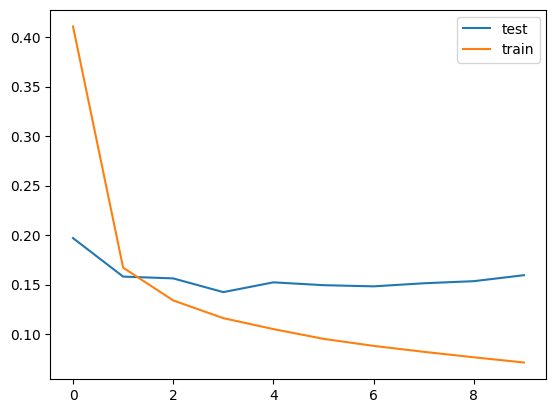

In [8]:
plt.plot(test_losses, label="test")
plt.plot(train_losses, label="train")
plt.legend()
plt.show()

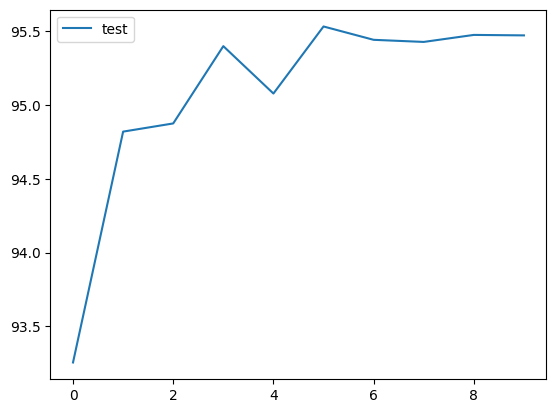

In [9]:
#plt.plot(train_accuracies, label="train")
plt.plot(test_accuracies, label="test")
plt.legend()
plt.show()

In [12]:
model.load_state_dict(torch.load(f'models/{run_name}' + f'-acc{max_accuracy:.2f}.pth', weights_only=True))

def predict(model, word, char_to_idx):
    model.eval()
    word_indices = [char_to_idx[char] for char in word.lower()]
    word_tensor = torch.tensor(word_indices, dtype=torch.long).unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(word_tensor)

        idx = torch.argmax(output, dim=1).item()

    idx_to_artikel = {v: k for k, v in artikel_to_idx.items()}

    return idx_to_artikel[idx]

# Example usage
print(predict(model, "Vatter", char_to_idx))

der
